In [113]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

ROOT_PATH = Path(".")
DATASET_PATH = ROOT_PATH / "csiro-biomass"

**Loading the Dataframe**

In [114]:
train_df = pl.read_csv(DATASET_PATH / "train.csv")
train_df.head()

sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
str,str,str,str,str,f64,f64,str,f64
"""ID1011485656__Dry_Clover_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Clover_g""",0.0
"""ID1011485656__Dry_Dead_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Dead_g""",31.9984
"""ID1011485656__Dry_Green_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Green_g""",16.2751
"""ID1011485656__Dry_Total_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Total_g""",48.2735
"""ID1011485656__GDM_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""GDM_g""",16.275


**Important Information for the Tabular Features**
- `sample_id` — Unique identifier for each training sample (image).
- `image_path` — Relative path to the training image (e.g., images/ID1098771283.jpg).
- `Sampling_Date` — Date of sample collection.
- `State` — Australian state where sample was collected.
- `Species` — Pasture species present, ordered by biomass (underscore-separated).
- `Pre_GSHH_NDVI` — Normalized Difference Vegetation Index (GreenSeeker) reading.
    - A high NDVI value (closer to 1) means the plants are lush, dense, and healthy.
    - A low NDVI value (closer to 0 or even negative) can indicate sparse vegetation, unhealthy plants, or non-vegetation like soil or water.
- `Height_Ave_cm` — Average pasture height measured by falling plate (cm).
- `target_name` — Biomass component name for this row (Dry_Green_g, Dry_Dead_g, Dry_Clover_g, GDM_g, or Dry_Total_g). This is independent of the names of the species.
- `target` — Ground-truth biomass value (grams) corresponding to target_name for this image.

**Checking the Image Paths**

In [115]:
def check_image_paths(img_path: str) -> bool:
    """Function to check all the image paths exist."""
    if (DATASET_PATH / img_path).exists():
        return True
    else:
        return False
    
# Mapping the series to the helper function.
df_image_checks = train_df.with_columns(
    pl.col("image_path").map_elements(check_image_paths).alias("image_exists")
)
df_image_checks

sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,image_exists
str,str,str,str,str,f64,f64,str,f64,bool
"""ID1011485656__Dry_Clover_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Clover_g""",0.0,true
"""ID1011485656__Dry_Dead_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Dead_g""",31.9984,true
"""ID1011485656__Dry_Green_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Green_g""",16.2751,true
"""ID1011485656__Dry_Total_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Total_g""",48.2735,true
"""ID1011485656__GDM_g""","""train/ID1011485656.jpg""","""2015/9/4""","""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""GDM_g""",16.275,true
…,…,…,…,…,…,…,…,…,…
"""ID983582017__Dry_Clover_g""","""train/ID983582017.jpg""","""2015/9/1""","""WA""","""Ryegrass""",0.64,9.0,"""Dry_Clover_g""",0.0,true
"""ID983582017__Dry_Dead_g""","""train/ID983582017.jpg""","""2015/9/1""","""WA""","""Ryegrass""",0.64,9.0,"""Dry_Dead_g""",0.0,true
"""ID983582017__Dry_Green_g""","""train/ID983582017.jpg""","""2015/9/1""","""WA""","""Ryegrass""",0.64,9.0,"""Dry_Green_g""",40.94,true


In [116]:
found_images = df_image_checks.filter(pl.col("image_exists")).select(pl.col("image_path"))
found_images

image_path
str
"""train/ID1011485656.jpg"""
"""train/ID1011485656.jpg"""
"""train/ID1011485656.jpg"""
"""train/ID1011485656.jpg"""
"""train/ID1011485656.jpg"""
…
"""train/ID983582017.jpg"""
"""train/ID983582017.jpg"""
"""train/ID983582017.jpg"""


In [117]:
not_found_images = df_image_checks.filter(~ pl.col("image_exists")).select(pl.col("image_path"))
not_found_images

image_path
str


## Initial Data Exploration and Visualisation

**Viewing the Distribution of the Species**

In [118]:
counts_species = train_df.select(pl.col("Species").value_counts()).unnest("Species")
counts_species

Species,count
str,u32
"""Fescue""",140
"""Phalaris_Ryegrass_Clover""",40
"""Clover""",205
"""Phalaris""",40
"""Phalaris_BarleyGrass_SilverGra…",55
…,…
"""Ryegrass_Clover""",490
"""Lucerne""",110
"""Ryegrass""",310


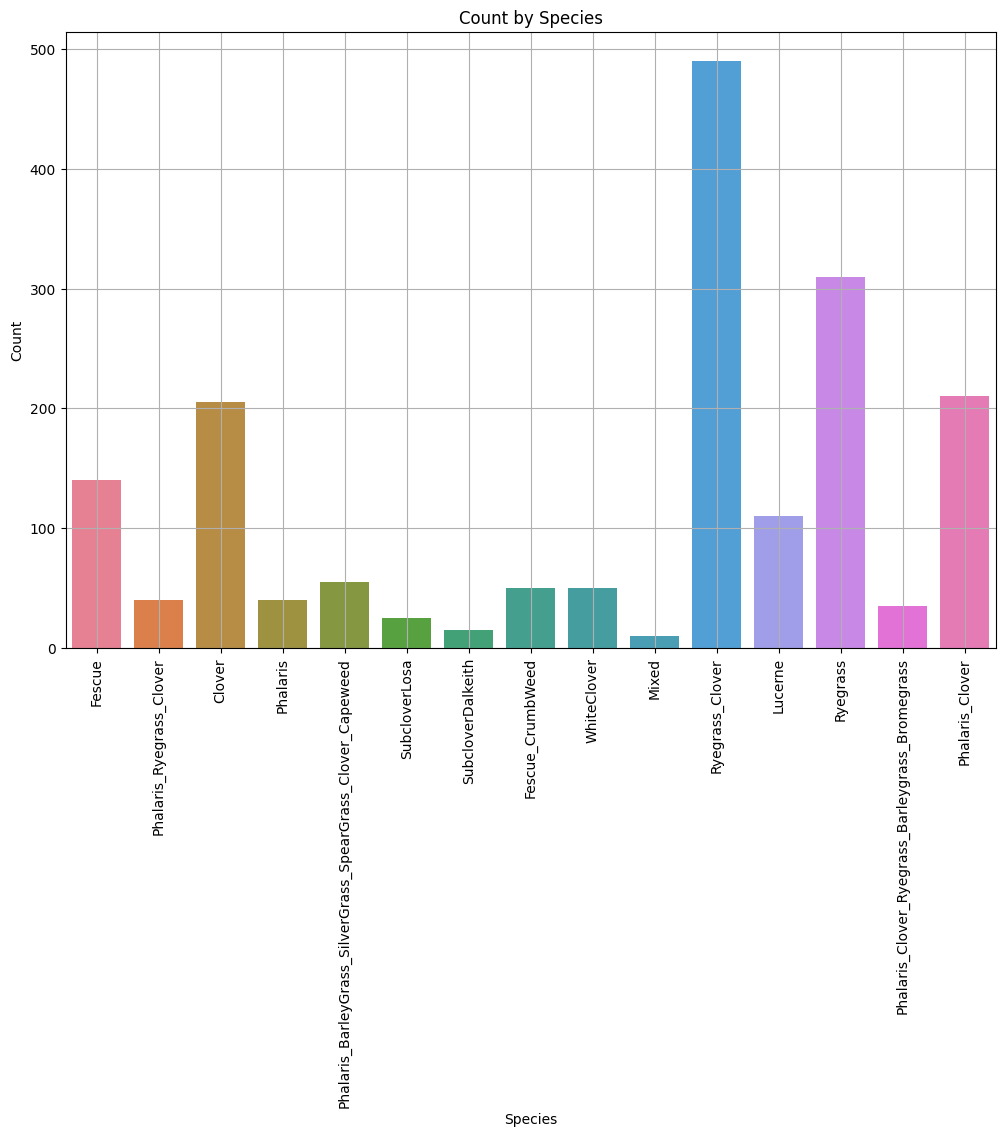

In [119]:
plt.figure(figsize=(12, 8))
sns.barplot(counts_species, x="Species", y="count", hue="Species")
plt.title("Count by Species")
plt.xlabel("Species")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.grid()
plt.show()

**Viewing the distribution of the Targets**

In [120]:
counts_targets = train_df.select(pl.col("target_name").value_counts()).unnest("target_name")
counts_targets

target_name,count
str,u32
"""Dry_Dead_g""",357
"""Dry_Clover_g""",357
"""Dry_Green_g""",357
"""GDM_g""",357
"""Dry_Total_g""",357


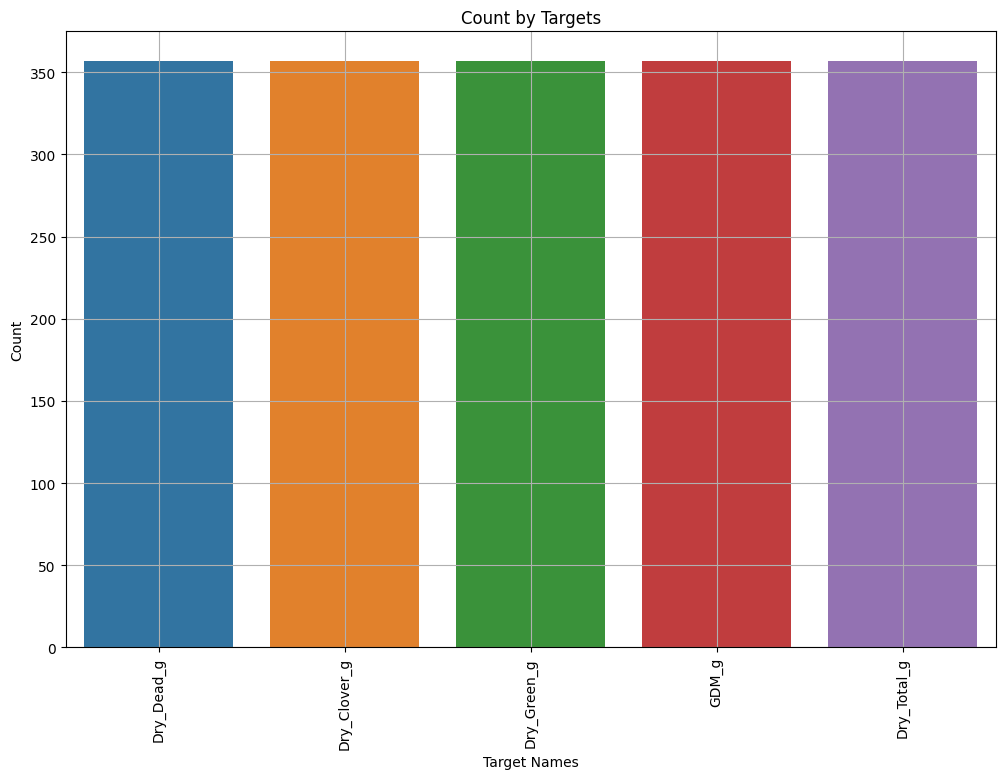

In [121]:
plt.figure(figsize=(12, 8))
sns.barplot(counts_targets, x="target_name", y="count", hue="target_name")
plt.title("Count by Targets")
plt.xlabel("Target Names")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.grid()
plt.show()

**Viewing the Relationship between Target (Number), NDVI and Target Names**

<Figure size 1500x800 with 0 Axes>

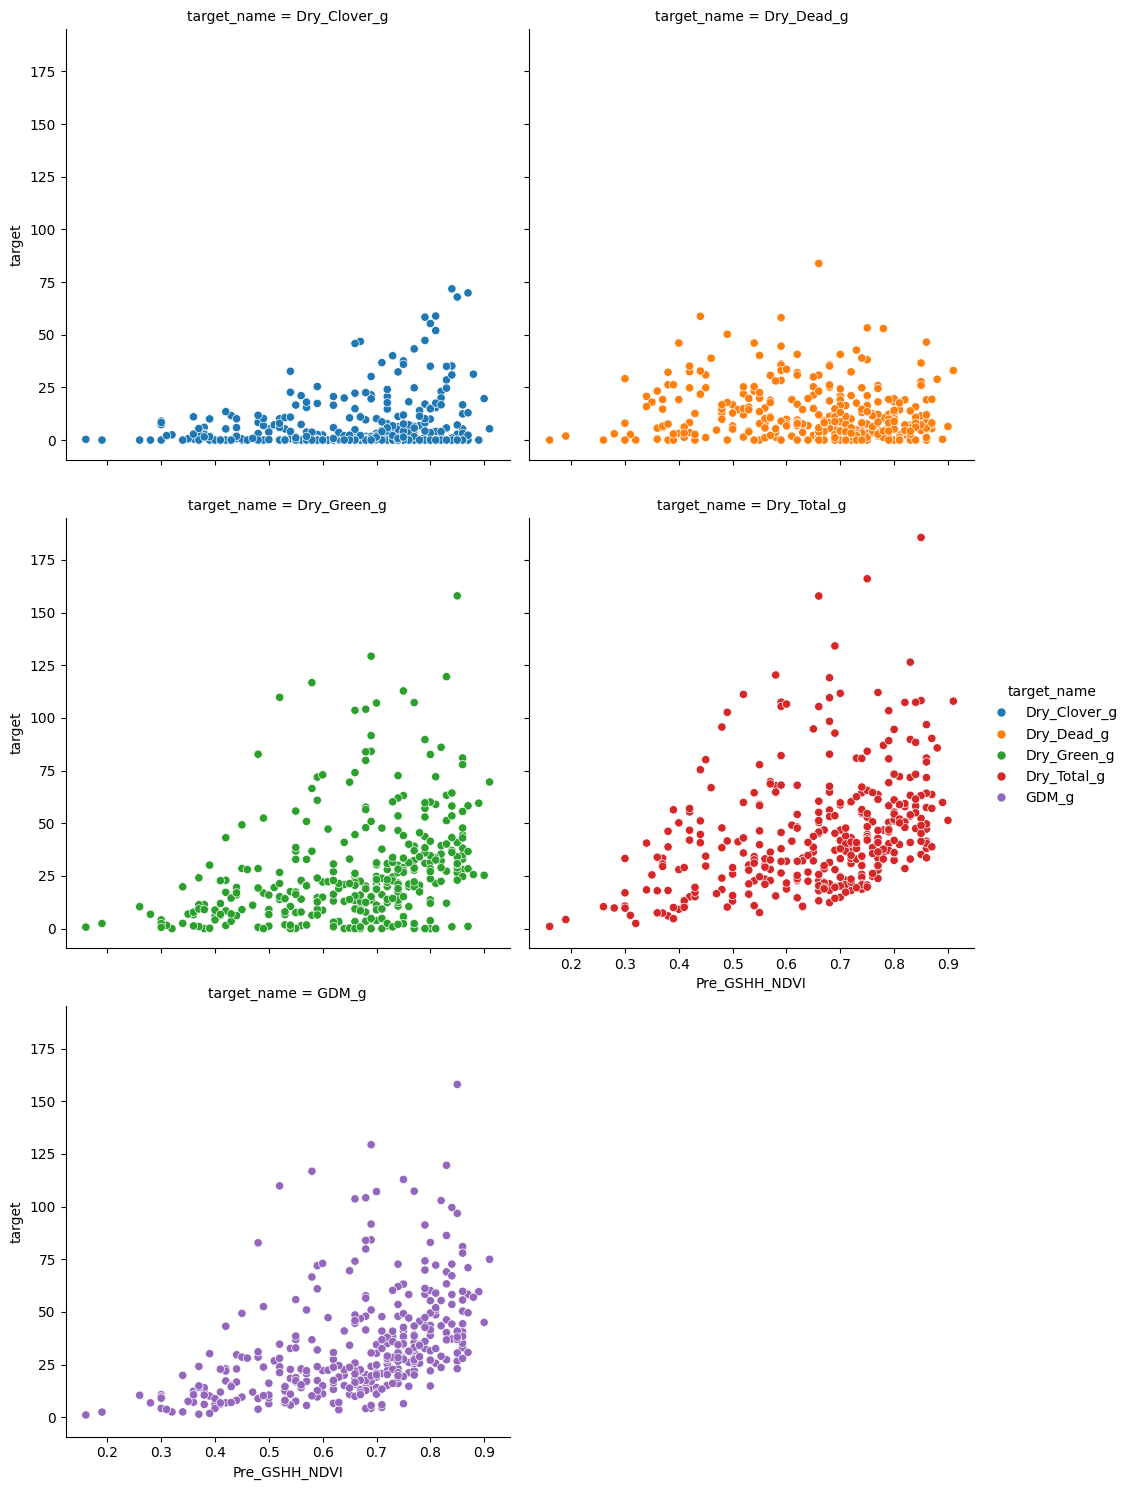

In [122]:
plt.figure(figsize=(15, 8))
sns.relplot(
    train_df, x="Pre_GSHH_NDVI", y="target", col="target_name", hue="target_name", col_wrap=2
)
plt.show()

**Viewing the Relationship between Target (Number), NDVI and Target Names by Season**

In [123]:
# Converting the Sampling_Date: str => Sampling_Date: date
train_df_seasons = train_df.with_columns(
    pl.col("Sampling_Date").str.to_date()
)

# Deciphering the Months
train_df_seasons = train_df_seasons.with_columns(
    pl.col("Sampling_Date").dt.month().alias("Sample_Month")
)

# Deciphering the Seasons
train_df_seasons = train_df_seasons.with_columns(
    pl.col("Sample_Month"),
    pl.when(pl.col("Sample_Month").is_in([12, 1, 2])).then(pl.lit("Summer"))
    .when(pl.col("Sample_Month").is_in([3, 4, 5])).then(pl.lit("Autumn"))
    .when(pl.col("Sample_Month").is_in([6, 7, 8])).then(pl.lit("Winter"))
    .when(pl.col("Sample_Month").is_in([9, 10, 11])).then(pl.lit("Spring"))
    .otherwise(pl.lit("unknown")).alias("Sample_Season")
)

train_df_seasons

sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,Sample_Month,Sample_Season
str,str,date,str,str,f64,f64,str,f64,i8,str
"""ID1011485656__Dry_Clover_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Clover_g""",0.0,9,"""Spring"""
"""ID1011485656__Dry_Dead_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Dead_g""",31.9984,9,"""Spring"""
"""ID1011485656__Dry_Green_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Green_g""",16.2751,9,"""Spring"""
"""ID1011485656__Dry_Total_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Total_g""",48.2735,9,"""Spring"""
"""ID1011485656__GDM_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""GDM_g""",16.275,9,"""Spring"""
…,…,…,…,…,…,…,…,…,…,…
"""ID983582017__Dry_Clover_g""","""train/ID983582017.jpg""",2015-09-01,"""WA""","""Ryegrass""",0.64,9.0,"""Dry_Clover_g""",0.0,9,"""Spring"""
"""ID983582017__Dry_Dead_g""","""train/ID983582017.jpg""",2015-09-01,"""WA""","""Ryegrass""",0.64,9.0,"""Dry_Dead_g""",0.0,9,"""Spring"""
"""ID983582017__Dry_Green_g""","""train/ID983582017.jpg""",2015-09-01,"""WA""","""Ryegrass""",0.64,9.0,"""Dry_Green_g""",40.94,9,"""Spring"""


<Figure size 1500x800 with 0 Axes>

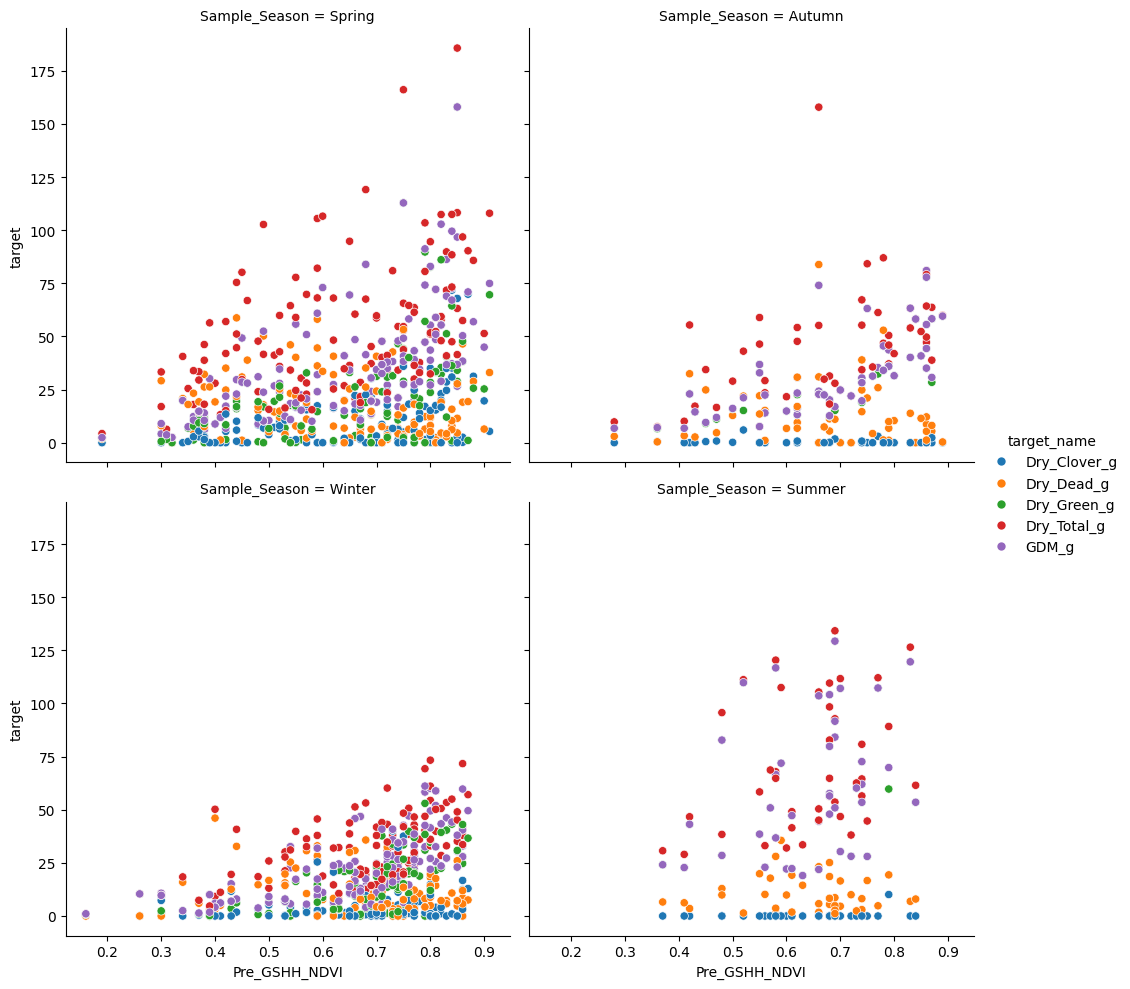

In [124]:
plt.figure(figsize=(15, 8))
sns.relplot(
    train_df_seasons, x="Pre_GSHH_NDVI", y="target", col="Sample_Season", hue="target_name", col_wrap=2
)
plt.show()

**Analysing the winter anomaly**

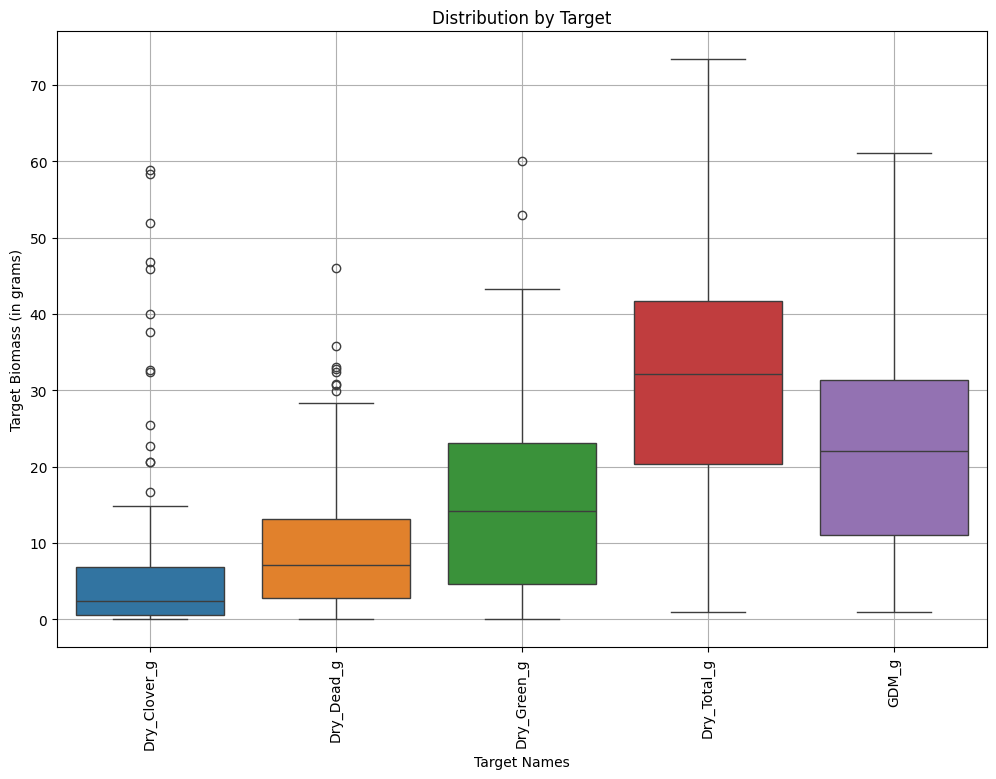

In [125]:
train_df_winter = train_df_seasons.filter(
    pl.col("Sample_Season") == "Winter"
)

# Viewing the Distribution by Target
plt.figure(figsize=(12, 8))
sns.boxplot(
    train_df_winter, x="target_name", y="target", hue="target_name"
)
plt.title("Distribution by Target")
plt.grid()
plt.xlabel("Target Names")
plt.ylabel("Target Biomass (in grams)")
plt.xticks(rotation=90)
plt.show()

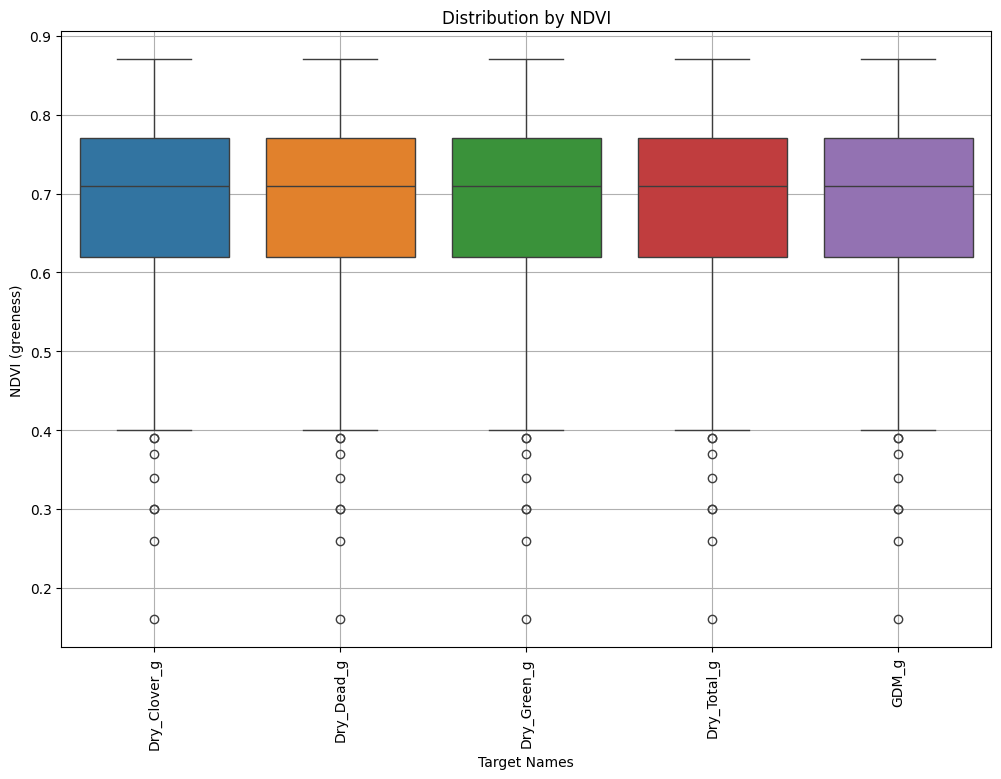

In [126]:
# Viewing the Distribution by NDVI
plt.figure(figsize=(12, 8))
sns.boxplot(
    train_df_winter, x="target_name", y="Pre_GSHH_NDVI", hue="target_name"
)
plt.title("Distribution by NDVI")
plt.grid()
plt.xlabel("Target Names")
plt.ylabel("NDVI (greeness)")
plt.xticks(rotation=90)
plt.show()

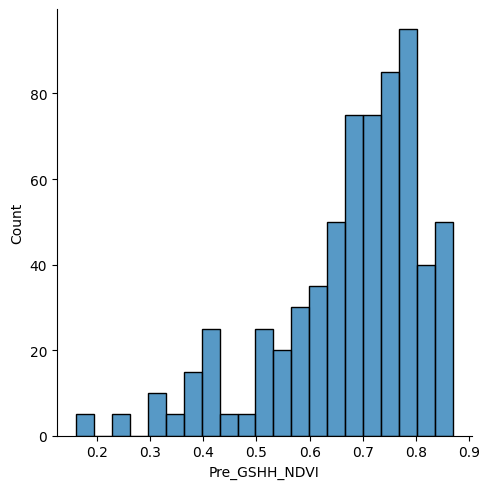

In [127]:
sns.displot(train_df_winter, x="Pre_GSHH_NDVI")

**Review**
- This happens because Pre_GSHH_NDVI (and Height_Ave_cm, Species, etc.) are image-level features. They describe the overall state of the pasture in that one photograph. The five different target values are the specific components that were measured from that single sample.
- You've just proven that the data is in a "long" format, where image-level features are repeated for each measurement type. This is a critical insight for when we eventually think about building a model.

**Analysing the Contribution of Species to Target Names**

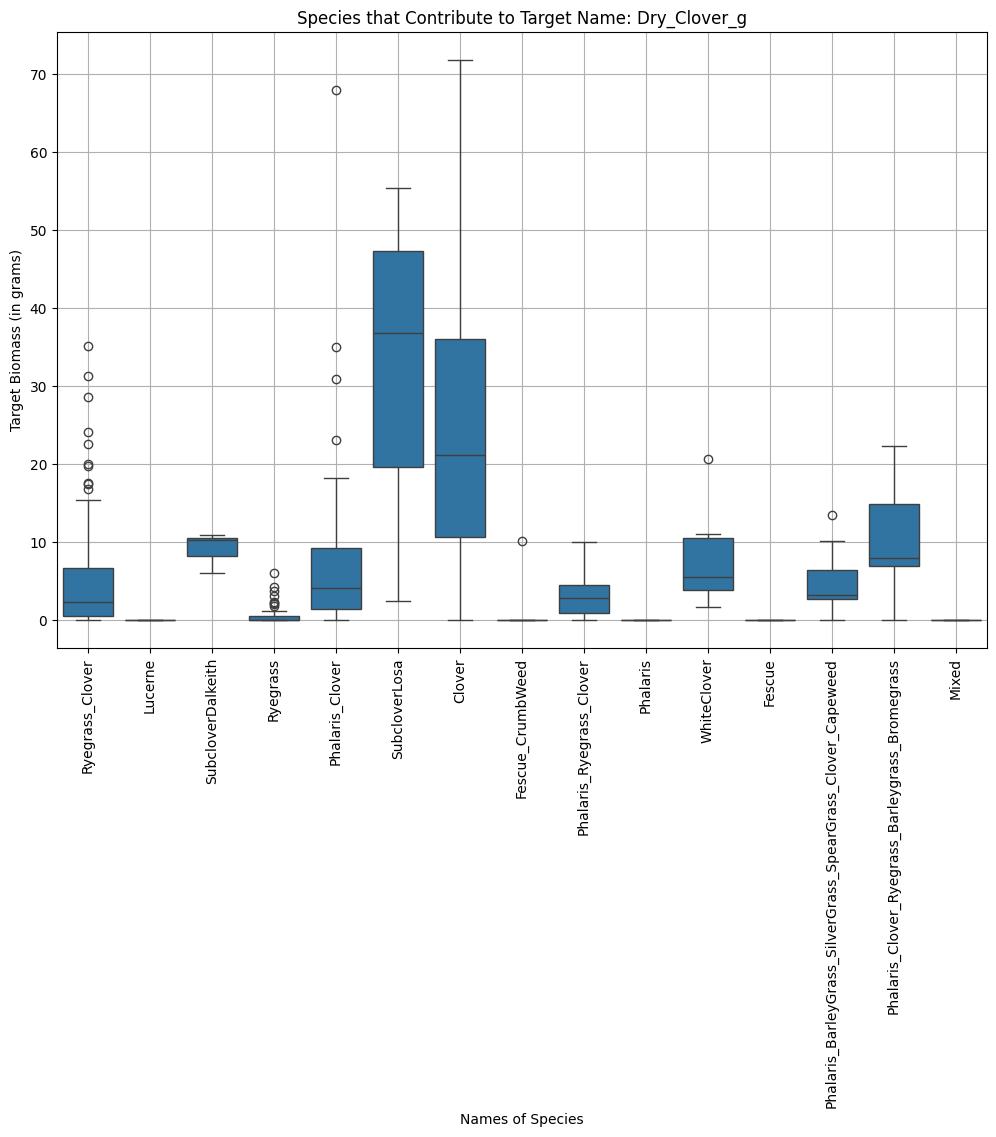

In [128]:
train_df_seasons_dry_clover = train_df_seasons.filter(
    pl.col("target_name") == "Dry_Clover_g"
)

plt.figure(figsize=(12, 8))
sns.boxplot(
    train_df_seasons_dry_clover, x="Species", y="target"
)
plt.title("Species that Contribute to Target Name: Dry_Clover_g")
plt.xlabel("Names of Species")
plt.ylabel("Target Biomass (in grams)")
plt.xticks(rotation=90)
plt.grid()
plt.show()

**Review**
- Species contribute significantly to identifying the biomass target class and target value.
- This can have more interaction with the season.

**Viewing the realtionship between Species and Height Average**

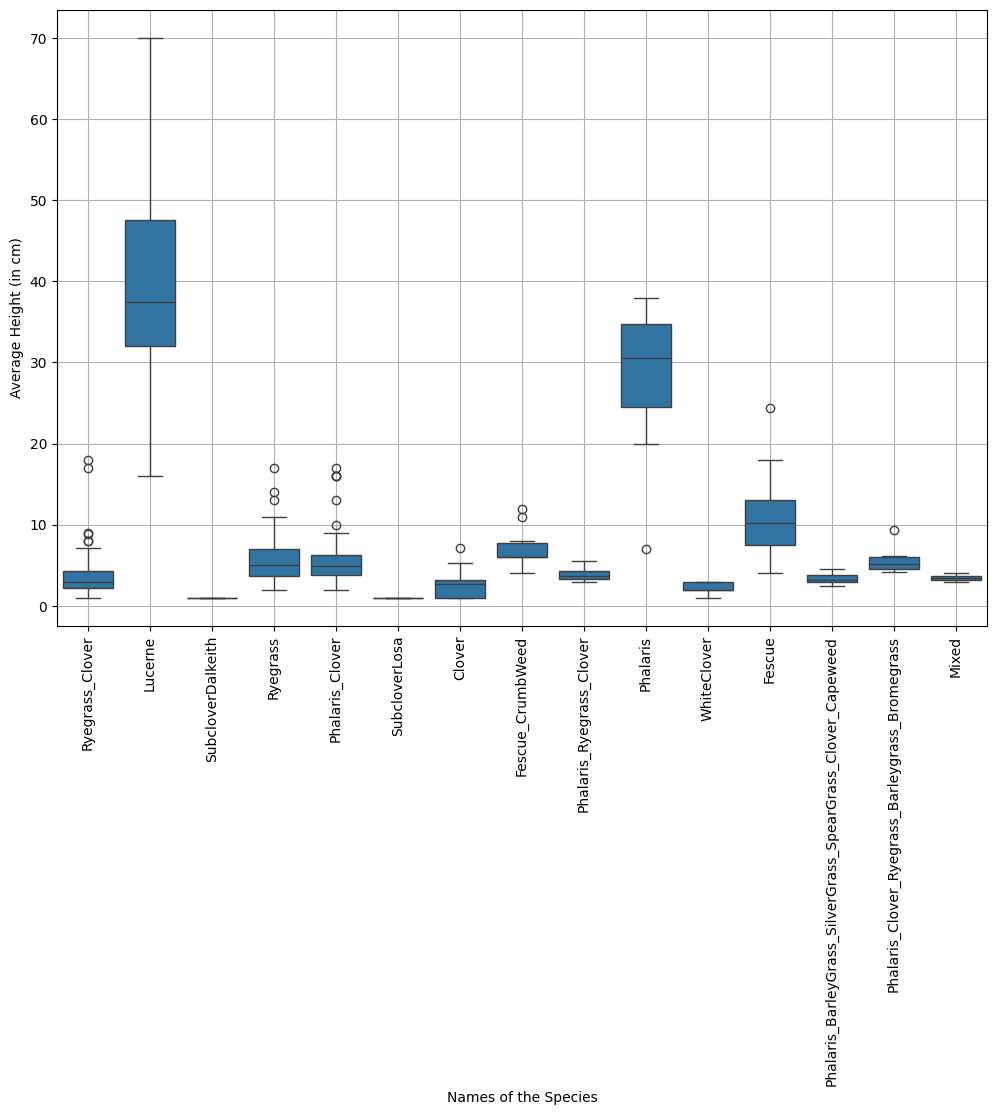

In [129]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    train_df_seasons_dry_clover, x="Species", y="Height_Ave_cm"
)
plt.xlabel("Names of the Species")
plt.ylabel("Average Height (in cm)")
plt.xticks(rotation=90)
plt.grid()
plt.show()

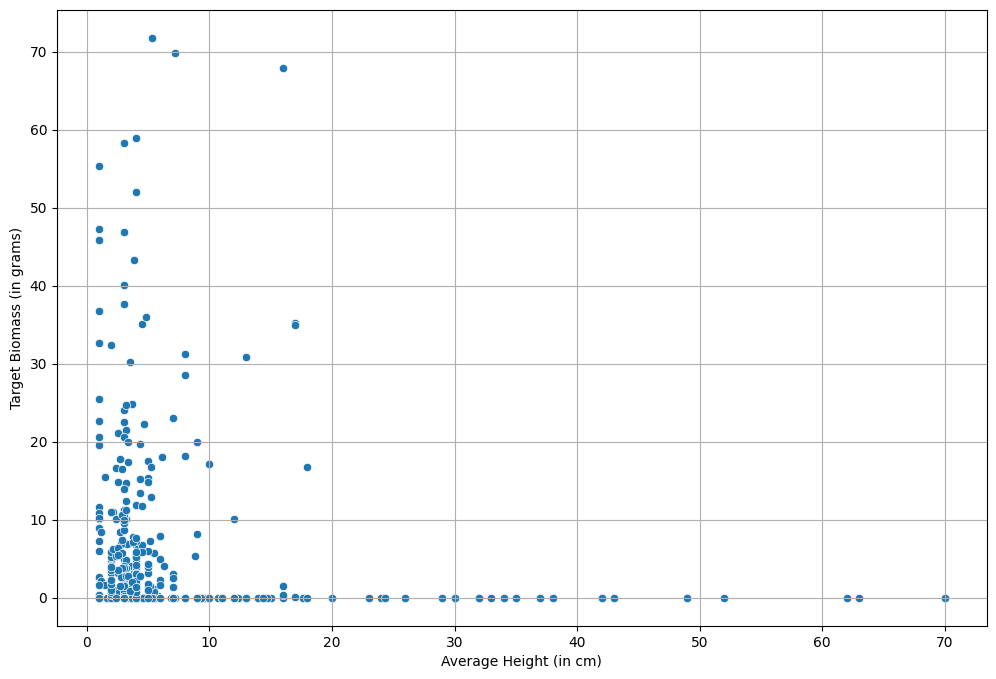

In [130]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    train_df_seasons_dry_clover, x="Height_Ave_cm", y="target"
)
plt.xlabel("Average Height (in cm)")
plt.ylabel("Target Biomass (in grams)")
plt.grid()
plt.show()

In [131]:
train_df_seasons.head()

sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,Sample_Month,Sample_Season
str,str,date,str,str,f64,f64,str,f64,i8,str
"""ID1011485656__Dry_Clover_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Clover_g""",0.0,9,"""Spring"""
"""ID1011485656__Dry_Dead_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Dead_g""",31.9984,9,"""Spring"""
"""ID1011485656__Dry_Green_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Green_g""",16.2751,9,"""Spring"""
"""ID1011485656__Dry_Total_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""Dry_Total_g""",48.2735,9,"""Spring"""
"""ID1011485656__GDM_g""","""train/ID1011485656.jpg""",2015-09-04,"""Tas""","""Ryegrass_Clover""",0.62,4.6667,"""GDM_g""",16.275,9,"""Spring"""


In [132]:
print(train_df_seasons.select("Species").unique())

shape: (15, 1)
┌─────────────────────────────────┐
│ Species                         │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Fescue_CrumbWeed                │
│ SubcloverDalkeith               │
│ Phalaris_Clover                 │
│ Ryegrass_Clover                 │
│ Fescue                          │
│ …                               │
│ Mixed                           │
│ Phalaris                        │
│ SubcloverLosa                   │
│ Ryegrass                        │
│ Phalaris_BarleyGrass_SilverGra… │
└─────────────────────────────────┘


## Final Review of the Tabular Data

Key Findings for Modeling

   * Data Structure: The data is in a "long" format. For modeling, we will need to transform it into a "wide" format, where each row represents a unique image and the five target_name values
     become five separate target columns to predict.
   * Strongest Predictors:
       * NDVI (`Pre_GSHH_NDVI`): This is a very strong predictor. It has a clear positive correlation with green biomass (Dry_Green_g, GDM_g) and is less correlated with dead biomass, as
         expected.
       * Season (`Sample_Season`): This is a critical feature. The relationships between features and targets change dramatically depending on the season (e.g., strong growth in Spring). This
         will be essential for the model to learn seasonal patterns.
   * Important Feature Engineering Candidates:
       * Species: This feature is highly valuable. The presence of a species name (e.g., "Clover") is a good indicator for its corresponding biomass type (e.g., Dry_Clover_g). We should engineer
         new features from this string, such as creating binary flags (e.g., has_clover, has_ryegrass).
   * Weaker/Secondary Predictors:
       * Height (`Height_Ave_cm`): Shows no strong, direct linear correlation with biomass targets. We should keep it in our dataset, as it may provide value in non-linear models or in
         interaction with other features, but it's likely less important than NDVI and Season.
   * Data Integrity: All image paths in the dataset are valid.